In [35]:
print("hola amigo")

hola amigo


In [37]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [38]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

In [39]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [40]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [41]:
len(dataset)
# 68*32 = 2176; ie batches of all images

68

In [42]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 1 0 1 1 1 1 2 0 0 0 1 0 0 0 1 0 1 1 0 2 0 1 0 0 0 1 0]


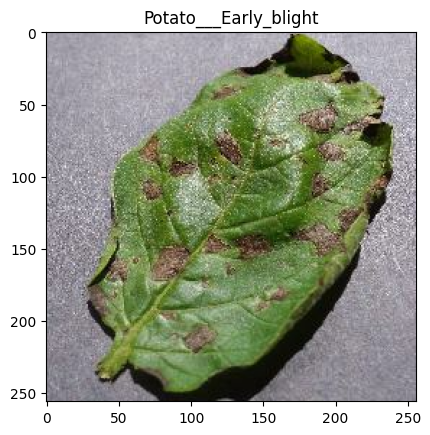

In [43]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

In [44]:
# # 80% => train
# # 20% => 10% validation + 10% test
train_size = 0.8
# len(dataset) * train_size
# train_ds = dataset.take(54)
# len(train_ds)
# test_ds = dataset.skip(54)
# len(test_ds)
# val_size = 0.1
# len(dataset) * val_size
# val_ds = test_ds.take(6)
# len(val_ds)
# test_ds = test_ds.skip(6)
# len(test_ds)

def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [46]:
print(len(dataset) * train_size)
print(len(val_ds))
print(len(test_ds))

54.400000000000006
6
8


In [47]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [48]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [49]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [50]:
# image > convoluton+relu > pooling > convolution+relu > pooling > flatten > is this a dog??

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [51]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [53]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4592 - loss: 0.9523 - val_accuracy: 0.7135 - val_loss: 0.8187
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6645 - loss: 0.7489 - val_accuracy: 0.7240 - val_loss: 0.5909
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7490 - loss: 0.5308 - val_accuracy: 0.8281 - val_loss: 0.4270
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8527 - loss: 0.3315 - val_accuracy: 0.9115 - val_loss: 0.2072
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9111 - loss: 0.2236 - val_accuracy: 0.9219 - val_loss: 0.1675
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9053 - loss: 0.2138 - val_accuracy: 0.8594 - val_loss: 0.2832
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9277 - loss: 0.1788 - val_accuracy: 0.9531 - val_loss: 0.1247
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9539 - loss: 0.1343 - val_accuracy: 0.9635 - val_loss:

In [54]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.9853 - loss: 0.0581


In [55]:
scores

[0.05690250173211098, 0.98046875]

In [56]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [57]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [58]:
history.history['accuracy']

[0.5115740895271301,
 0.6869212985038757,
 0.7829861044883728,
 0.8645833134651184,
 0.9178240895271301,
 0.9137731194496155,
 0.9369212985038757,
 0.9571759104728699,
 0.9282407164573669,
 0.9612268805503845,
 0.9623842835426331,
 0.9774305820465088,
 0.9791666865348816,
 0.9907407164573669,
 0.9618055820465088]

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

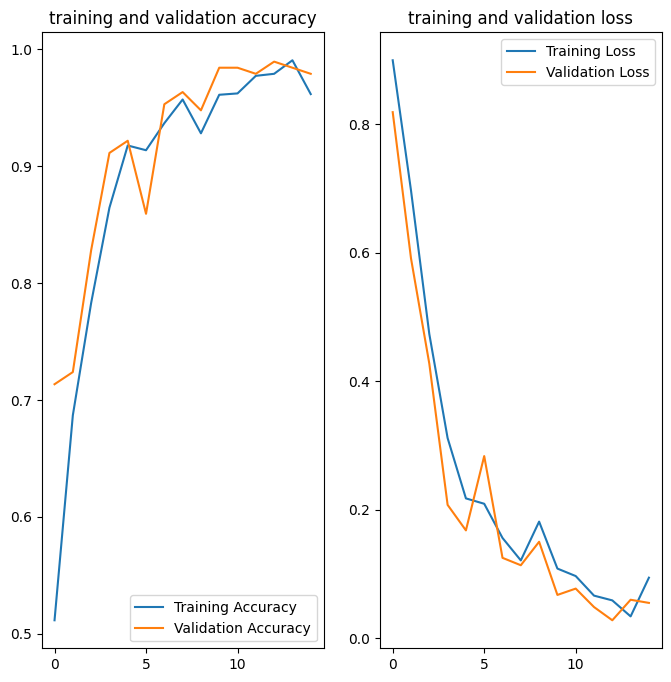

In [60]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("training and validation loss")

In [61]:
import numpy as np
np.argmax([9, 2, 12, 100])

3

In [1]:
# import numpy as np
# for images_batch, labels_batch in test_ds.take(1):
#     first_image = plt.imshow(images_batch[0].numpy().astype('uint8'))
#     first_label = labels_batch[0].numpy()
#     print(f"actual label : {class_names[first_label]}")

#     batch_prediction = model.predict(images_batch)
#     print(f"predicted label: {class_names[np.argmax(batch_prediction[0])]}")

def predict(model, images):
    img_array = tf.keras.preprocessing.image.img_to_array(images[0].numpy())
    img_array = tf.expand_dims(img_array, 0) #creating a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual label      : {actual_class}\npredicted label : {predicted_class}\nconfidence : {confidence}%")
        plt.axis("off")

In [3]:
# import os
# model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
# model.save(f"../models/{model_version}.keras")

In [65]:
model_version = 1
model.save(f"D:/_programming/Potato-Disease-Classification-System-using-Convolutional-Neural-Networks-CNN/saved_models/{model_version}.keras")

In [ ]:
# Step 1: Install the necessary packages
!pip install pyngrok
!pip install -r "requirements.txt"

You should consider upgrading via the 'C:\Users\ASUS\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
!ngrok authtoken 2ioz4KXy12YAwiMV6Zo84Haun8W_6j9wVkAeJX6LPVUrGRTr3

Authtoken saved to configuration file: C:\Users\ASUS\AppData\Local/ngrok/ngrok.yml


In [ ]:
!nohup streamlit run streamlit_app.py &

In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(8501)
print(public_url)

In [1]:
# NgrokTunnel: "https://ec33-34-106-160-128.ngrok-free.app" -> "http://localhost:8501"
